## OpenFDA Durg Event Endpoint Analysis

Author: Sanketh Nagarajan <br>
API: https://open.fda.gov/apis/drug/event/ <br> <br>

### Exploration 3: 

Given a snapshot of patient details / history and the adverse event experienced, can a medical practioner find the most likely associated active ingredients?


### Approach:

We are exploring the relationship between: Age, Sex, Disease area, Adverse event and Active ingredient

'Adult' and 'Elderly' age groups are considered since most reports fall under  this age category. Top 3 disease areas are considered (ordered by counts) and the top 10 adverse events associated with these disease areas are considered (from **Exploration: 2**). For each combination of these 4 variables (including 'Sex'), we find the top 3 associated active ingredients using **tf-idf** weights. This particular way of analysis was chosen because it doesn't require massive data downloads and keeps the analysis quick. Ideally we would have to go report-by-report, drug-by-drug and then correlate which drug, active ingredient, disease area and adverse event are associated.

Event reports from a medical professional (Phycisian / Pharmacist / Other health professional) are the only ones considered so that we don't introduce bias. 

We also restrict the analysis time-frame to the last 1 year (Jan 1st 2019 to Dec 31st 2019) to work with the most recent data since a medicine's efficacy can change with time (through years of research)

In [1]:
# Imorting required libraries
import os
import sys
sys.path.insert(0, os.path.abspath('./Az_case_study'))  # Set current working directory path here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.query_utils import get_list_ordered_by_counts

# Initializing static variables
custom_date_range = '[20190101+TO+20191231]'  # Fixing time-range to last 1 year (most recent data)

##### Step 1: Data preparation

In [2]:
# Get the top 100 most frequent disease areas
disease_area_list, _ = get_list_ordered_by_counts(count_field='patient.drug.drugindication.exact', limit=100, custom_date_range=custom_date_range)

age_category_list = ['5', '6']
sex_list = ['1', '2']
disease_ind_list = disease_area_list[1:4]  # Selecting top 3 disease areas

# Associated adverse events were picked from exploring_prob_2.py
associated_adverse_events = ['DIZZINESS', 'DRUG INEFFECTIVE', 'BLOOD PRESSURE INCREASED',
                             'DYSPNOEA', 'INJECTION SITE PAIN', 'FATIGUE',
                             'GAIT DISTURBANCE', 'HEADACHE', 'FALL', 'INFLUENZA LIKE ILLNESS']

# Declaring translation dictionaries (used in plots)
age_translation_dict = {'5': 'Adult', '6': 'Elderly'}
sex_translation_dict = {'1': 'Male', '2': 'Female'}

##### Step 2: Finding active ingredient counts for each combination (of Age, Sex, Disease area & Adverse event)

In [3]:
# Storing the details of combinations tried (stored in index_df)
index_df = pd.DataFrame(columns=['age_bracket', 'sex', 'disease_indication', 'associated_adverse_event'])
active_ing_df = pd.DataFrame()  # This contains the count values for each combination and each active ingredient

filter_text = [''] * 5
counter = 0

# Setting a primary filter that event records should be from a medical professional
filter_text[0] = '(primarysource.qualification:1+2+3)'

for age in age_category_list:
    filter_text[1] = 'patient.patientagegroup:' + '"' + age + '"'

    for sex in sex_list:
        filter_text[2] = 'patient.patientsex:' + '"' + sex + '"'

        for disease in disease_ind_list:
            filter_text[3] = 'patient.drug.drugindication.exact:' + '"' + disease + '"'

            for adv_event in associated_adverse_events:
                filter_text[4] = 'patient.reaction.reactionmeddrapt.exact:' + '"' + adv_event + '"'

                # Finding count of top 100 active ingredients satisfying all previous conditions
                active_ing_list, active_ing_unique_counts = get_list_ordered_by_counts(count_field='patient.drug.activesubstance.activesubstancename.exact', limit=100,
                                                                                       custom_date_range=custom_date_range, filter_to_use='+AND+'.join(filter_text))

                index_df.loc[counter, 'age_bracket'] = age
                index_df.loc[counter, 'sex'] = sex
                index_df.loc[counter, 'disease_indication'] = disease
                index_df.loc[counter, 'associated_adverse_event'] = adv_event

                col_df = pd.DataFrame(columns=active_ing_list)
                col_df.loc[counter, :] = active_ing_unique_counts
                active_ing_df = pd.concat([active_ing_df, col_df], sort=True, axis=0)
                
                counter += 1

active_ing_df.fillna(0, inplace=True)

In [4]:
# Combinations tried
index_df

,age_bracket,sex,disease_indication,associated_adverse_event
0,5,1,RHEUMATOID ARTHRITIS,DIZZINESS
1,5,1,RHEUMATOID ARTHRITIS,DRUG INEFFECTIVE
2,5,1,RHEUMATOID ARTHRITIS,BLOOD PRESSURE INCREASED
3,5,1,RHEUMATOID ARTHRITIS,DYSPNOEA
4,5,1,RHEUMATOID ARTHRITIS,INJECTION SITE PAIN
...,...,...,...,...
115,6,2,HYPERTENSION,FATIGUE
116,6,2,HYPERTENSION,GAIT DISTURBANCE
117,6,2,HYPERTENSION,HEADACHE
118,6,2,HYPERTENSION,FALL


In [5]:
# Count values for each combination
active_ing_df

,.ALPHA.-LIPOIC ACID,.ALPHA.-TOCOPHEROL,".ALPHA.-TOCOPHEROL ACETATE, D-",".ALPHA.-TOCOPHEROL, D-",ABATACEPT,ABIRATERONE ACETATE,ACEBUTOLOL,ACEBUTOLOL HYDROCHLORIDE,ACETAMINOPHEN,ACETAMINOPHEN\BUTALBITAL\CAFFEINE,...,VORICONAZOLE,WARFARIN,WARFARIN SODIUM,WATER,ZINC,ZOFENOPRIL,ZOLEDRONIC ACID,ZOLPIDEM TARTRATE,ZOLPIDEM\ZOLPIDEM TARTRATE,ZOPICLONE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
118,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


We maintain 2 separate DataFrames just to make computations on the count values easier. Combining future results with the **index_df** table would just require an index based merge

##### Step 3: Calculating TF-IDF weigths to find the most relevant associations (between each variable combination and active ingredient)

For more information on **tf-idf** weights please refer to **"./prob_2_explanation.ipynb"**

In [6]:
# Calculating TF-IDF to find the most relevant correlations
# (between each variable combination and the active ingredient)
# --------------------------------------------------------------

def tf_idf_calculator(data):

    # Finding TF-IDF weights for a given matrix treating each column as a term and each row as a document
    # ----------------------------------------------------------------------------------------------------

    # Step 1: Calculate term frequency for each document
    tf_matrix = data / data.sum(axis=1).values.reshape(-1, 1)

    # Step 2: Computing the inverse document frequency (IDF)
    # IDF = Log10(Total number of records / Number of records with the specific adverse event contained in it)
    idf_vector = np.log10(np.sum(data.values) / data.sum(axis=0))

    # Step 3: Construct TF-IDF weighted matrix
    tf_idf_matrix = tf_matrix * idf_vector.values.reshape(1, -1)

    return tf_idf_matrix


active_ing_tf_idf = tf_idf_calculator(active_ing_df)

In [7]:
active_ing_tf_idf

,.ALPHA.-LIPOIC ACID,.ALPHA.-TOCOPHEROL,".ALPHA.-TOCOPHEROL ACETATE, D-",".ALPHA.-TOCOPHEROL, D-",ABATACEPT,ABIRATERONE ACETATE,ACEBUTOLOL,ACEBUTOLOL HYDROCHLORIDE,ACETAMINOPHEN,ACETAMINOPHEN\BUTALBITAL\CAFFEINE,...,VORICONAZOLE,WARFARIN,WARFARIN SODIUM,WATER,ZINC,ZOFENOPRIL,ZOLEDRONIC ACID,ZOLPIDEM TARTRATE,ZOLPIDEM\ZOLPIDEM TARTRATE,ZOPICLONE
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.058573,0.0,0.000000,0.000000,0.018773,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.012276
2,0.0,0.0,0.0,0.0,0.057227,0.0,0.000000,0.000000,0.066029,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.072948,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.038684,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
116,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.057502,0.056917,0.0,0.0,0.0,0.000000,0.0,0.063608,0.000000
117,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.013298,0.0,...,0.0,0.000000,0.043478,0.0,0.0,0.0,0.000000,0.0,0.000000,0.021739
118,0.0,0.0,0.0,0.0,0.000000,0.0,0.029874,0.016161,0.054488,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.025451,0.0,0.000000,0.000000


The **tf-idf** weights for each active ingredient is shown above. Here, each column (active ingredient) is treated as a "term" and each row is treated as a "document" (corresponding to the rows in **index_df**). To derive useful insights from this table, we:
1. Derived the average of the top 3 tf-idf weights for each row
2. Sorted the rows by this new average (in descending order)

This sorts the rows in the order of most prominent to least prominent associations. The following code works on this principle to derive:
1. The top 5 prominent associations (and the top 3 associated active ingredients)
2. The top 3 associated active ingredients association under each disease area

In [8]:
def plot_relevant_correlations(top_5=True):

    # Data preparation
    # -----------------

    # Creating a row ranking metric to sort rows by the extend of correlation
    # (average of the top 3 association values in each row)
    sorted_active_ing_df = active_ing_df.copy()
    sorted_active_ing_df['top_3_avg'] = sorted_active_ing_df.apply(lambda row: np.mean(sorted(row)[-3:]), axis=1)

    if top_5:
        # If just the top 5 correlations are required, we sort by 'top_3_avg' column and keep the first 5 rows
        sorted_active_ing_df = sorted_active_ing_df.loc[sorted_active_ing_df.sort_values(
            by=['top_3_avg'], ascending=False).index[:5]]

    else:
        # Selecting the top entry for each disease area

        # Step 1: Sorting all rows by 'top_3_avg' metric
        sorted_active_ing_df = sorted_active_ing_df.loc[sorted_active_ing_df.sort_values(by=['top_3_avg'], 
                                                                                         ascending=False).index]

        # Step 2: Merging the index information
        # (details of combinations tried for the first 4 variables (except for active ingredient))
        merged_active_ing_df = pd.merge(index_df, sorted_active_ing_df, how='right', right_index=True, left_index=True)

        # Step 3: Keep the top correlation for each disease area and discard the rest
        merged_active_ing_df = merged_active_ing_df.drop_duplicates(subset=['disease_indication'], keep='first')
        sorted_active_ing_df = sorted_active_ing_df.loc[sorted_active_ing_df.index.isin(merged_active_ing_df.index)]

    # Drop the column used for sorting
    sorted_active_ing_df = sorted_active_ing_df.drop(columns=['top_3_avg'])

    # Plotting results
    # ----------------

    # Constructing xtick_labels
    xtick_list = []
    for idx in sorted_active_ing_df.index:
        row_values = index_df.loc[idx].values
        age_text = 'Age: ' + age_translation_dict[row_values[0]]
        sex_text = 'Sex: ' + sex_translation_dict[row_values[1]]
        disease_text = 'Disease: ' + row_values[2]
        event_text = 'Adverse event: ' + row_values[3]
        xtick_list.append('\n'.join([age_text, sex_text, disease_text, event_text]))

    # Constructing bar plot data
    y_value_list = []
    y_text_list = []
    for idx in sorted_active_ing_df.index:
        top_3_associated_ingredients = np.argsort(sorted_active_ing_df.loc[idx, :].values)[-3:]
        y_text = sorted_active_ing_df.columns[top_3_associated_ingredients].values
        y_values = sorted_active_ing_df.loc[idx, y_text].values

        y_value_list.append(y_values)
        y_text_list.append(y_text)

    y_value_array = np.concatenate(y_value_list).reshape(len(sorted_active_ing_df), 3)
    y_text_array = np.concatenate(y_text_list).reshape(len(sorted_active_ing_df), 3)

    # Plotting top 3 associated active ingredients for the top combinations
    # (sorted in the order of average association / tf-idf score)
    _, ax = plt.subplots()
    bar_width = 0.15
    bar_1 = ax.bar(np.arange(len(sorted_active_ing_df)), np.sqrt(y_value_array[:, 2]), bar_width)
    bar_2 = ax.bar(np.arange(len(sorted_active_ing_df)) + bar_width,  np.sqrt(y_value_array[:, 1]), bar_width)
    bar_3 = ax.bar(np.arange(len(sorted_active_ing_df)) + 2 * bar_width,  np.sqrt(y_value_array[:, 0]), bar_width)
    ax.set_xticks(np.arange(len(sorted_active_ing_df)) + bar_width)
    ax.set_xticklabels(xtick_list)

    # Annotating each bar
    for idx in range(len(y_text_array)):
        for association_idx, association in enumerate(y_text_array[idx]):
            ax.annotate(y_text_array[idx, association_idx], (
                idx + ((2 - association_idx) * bar_width) - 0.03,
                np.sqrt(y_value_array[idx, association_idx]) + 0.2),
                        fontsize=7, rotation=0)

    ax.legend((bar_1[0], bar_2[0], bar_3[0]), ('Active ingredient with association rank - 1',
                                               'Active ingredient with association rank - 2',
                                               'Active ingredient with association rank - 3'))
    plt.ylim([0, np.sqrt(np.max(y_value_array)) * 1.2])

    if top_5:
        plt.xlim([-0.5, 5])
        plt.title('Top 5 associations between\n'
                  '(Age, Sex, Disease area, Adverse event and Active ingredient)')
        plt.ylabel('Association score')

    else:
        plt.xlim([-0.5, 3])
        plt.title('Top 3 associations for each disease area between\n'
                  '(Age, Sex, Disease area, Adverse event and Active ingredient)')
        plt.ylabel('Association score')

    return

##### Step 4: Visualizing the most prominent associations

For visualization purposes, we scale the **tf-idf** weights using a square root transform

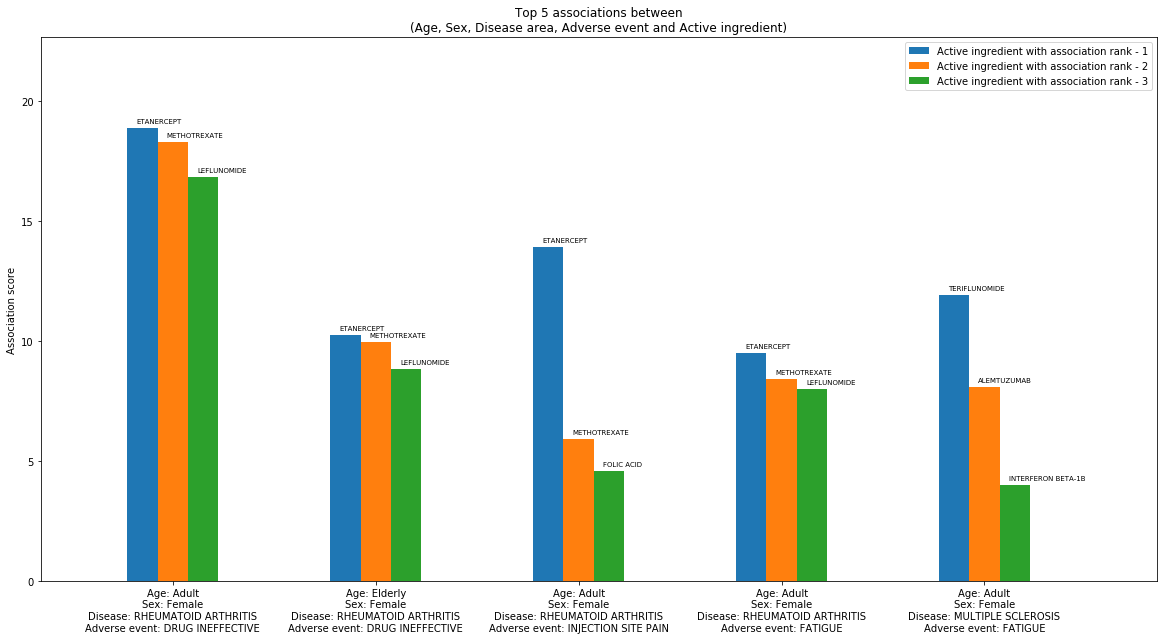

In [16]:
# Plot top 5 correlations
# ------------------------
plt.rcParams['figure.figsize'] = [20, 10]  # Fixing figure size
plot_relevant_correlations()

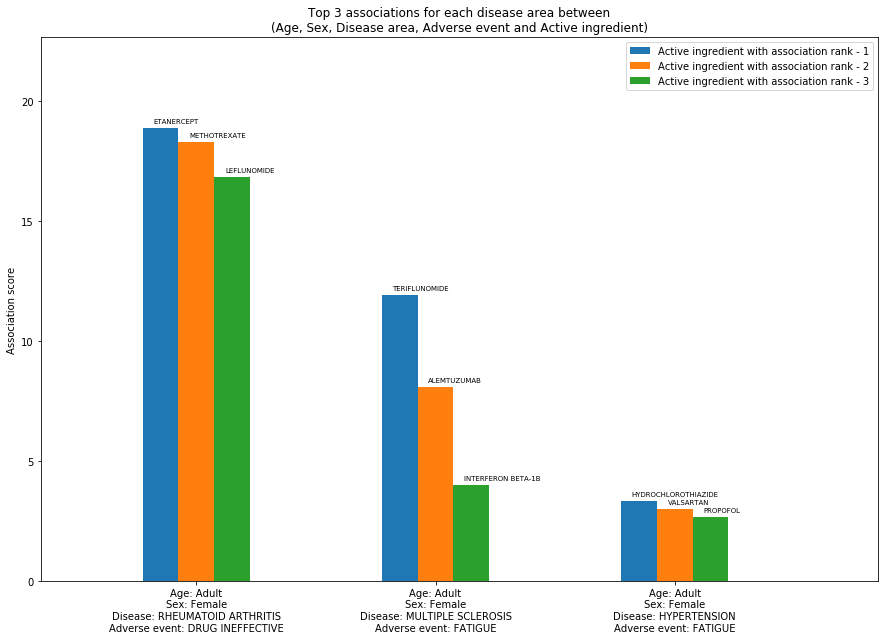

In [25]:
# Plot the top correlation for each disease area
# -----------------------------------------------
plt.rcParams['figure.figsize'] = [15, 10]  # Fixing figure size
plot_relevant_correlations(top_5=False)

It is interesting to see that within the same disease area we most probably get the same set of associated active ingredients. But for different adverse events the relative contribution between active ingredients vary considerably.

For example, in the **"Adult - Female patients with - Rheumatoid Arthritis"** category, the active ingredient which is most likely associated with **INJECTION SITE PAIN** is **ETANERCEPT**. But the same cannot be said with confidence in case of drug inffectiveness (all 3 active ingredients have more or less the same extent of association)

##### Conclusion:

Through these charts we can see that certain active ingredients have higher association to certain adverse events (for a given Age, Sex and Disease area). This could give more context to medical practitioners to further investigate if there are any causal relationships between these active ingredients, their dosage and different adverse events (given a patient's history)